## Project 4. Store sales prediction using Neural Networks: Continuation
with functions to speed up the experimenting process

### Code setup

In [52]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

#### Incredibly important: set random seed as stable - for experimentation consistency

In [31]:
tf.random.set_seed(111)

In [32]:
# base dataset
df_path  = '../datasets/walmart_sales.csv'
df = pd.read_csv(df_path)

In [33]:
numerical_types = ['int32','int64','float32','float64']

In [34]:
df_eng_path  = '../datasets/walmart_sales_engineered.csv'
df_eng = pd.read_csv(df_eng_path, index_col=0)

In [35]:
df_eng.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,...,weekly_sales_diff,temperature_diff,fuel_price_diff,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,...,0.00,0.00,0.000,0.000000,0.0,2.0,5,1.0,0.0,0.0
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,...,-1733.46,-3.80,-0.024,0.145812,0.0,2.0,5,1.0,0.0,1.0
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,...,-29989.27,1.42,-0.034,0.046973,0.0,2.0,6,2.0,1.0,-1.0
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,...,-202240.58,6.70,0.047,0.030500,0.0,2.0,7,3.0,0.0,0.0
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,...,145079.09,-0.13,0.064,0.030500,0.0,2.0,8,4.0,0.0,0.0


In [36]:
df_eng.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'weekly_sales_diff',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_month', 'prev_week_number', 'prev_week_of_month',
       'prev_holiday_flag', 'holiday_flag_diff'],
      dtype='object')

In [37]:
df_eng.dtypes

store                   int64
date                   object
weekly_sales          float64
holiday_flag            int64
temperature           float64
fuel_price            float64
cpi                   float64
unemployment          float64
week_number             int64
month                   int64
week_of_month           int64
prev_weekly_sales     float64
prev_temperature      float64
prev_fuel_price       float64
prev_cpi              float64
prev_unemployment     float64
weekly_sales_diff     float64
temperature_diff      float64
fuel_price_diff       float64
cpi_diff              float64
unemployment_diff     float64
prev_month            float64
prev_week_number        int64
prev_week_of_month    float64
prev_holiday_flag     float64
holiday_flag_diff     float64
dtype: object

### new base df: 'df_eng_proper' (no date, n oweekly_sales_diff)

In [38]:
df_eng_proper = df_eng.drop(['date', 'weekly_sales_diff'], axis=1)

### X and y scaling (separate)

In [39]:
X = df_eng_proper.drop(['weekly_sales'], axis=1)
y = df_eng_proper['weekly_sales']

In [40]:
X_cols = list(X.columns)
y_col = ['weekly_sales']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.75)

In [42]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train[X_cols])

MinMaxScaler()

In [43]:
scaler_y = MinMaxScaler()
scaler_y.fit(pd.DataFrame(y_train))

MinMaxScaler()

In [44]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

#### With scaling the target / output

In [45]:
X_train[X_cols] = scaler_X.transform(X_train[X_cols])
X_test[X_cols] = scaler_X.transform(X_test[X_cols])
y_train[y_col] = scaler_y.transform(y_train[y_col])
y_test = scaler_y.transform(y_test[y_col])

In [46]:
X_train.head()

,store,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,week_of_month,prev_weekly_sales,...,prev_unemployment,temperature_diff,fuel_price_diff,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff
3924,0.613636,0.0,0.726329,0.832665,0.028579,0.944700,0.294118,0.272727,0.75,0.285460,...,0.944700,0.795169,0.679783,0.460306,0.648528,0.272727,0.274510,0.50,0.0,0.5
4646,0.727273,0.0,0.872222,0.756012,0.029374,0.460801,0.431373,0.454545,0.25,0.009281,...,0.460801,0.597375,0.438263,0.367288,0.648528,0.454545,0.411765,0.00,0.0,0.5
3108,0.477273,1.0,0.369529,0.592685,0.148820,0.347326,0.098039,0.090909,0.25,0.207416,...,0.347326,0.426398,0.348711,0.555468,0.648528,0.090909,0.078431,0.00,0.0,1.0
999,0.136364,0.0,0.441300,0.640281,0.722399,0.352501,0.803922,0.818182,0.50,0.081325,...,0.352501,0.549639,0.305292,0.540153,0.648528,0.818182,0.784314,0.25,0.0,0.5
4555,0.704545,0.0,0.716734,0.635772,0.707641,0.403584,0.431373,0.454545,0.25,0.262580,...,0.403584,0.677444,0.287653,0.442187,0.648528,0.454545,0.411765,0.00,0.0,0.5


In [47]:
y_train.head()

,weekly_sales
3924,0.301346
4646,0.013423
3108,0.228465
999,0.084917
4555,0.287177


### Function to test regression NN models

In [63]:
def test_nn_model(model, X_train, X_test, y_train, y_test,
                  scaler_X, scaler_y,
                  optimizer=keras.optimizers.Adam,
                  metrics = None,
                  loss='mae', lr=0.001, batch_size=256, epochs=25,
                  verbose = False,
                  early_stop=True, lr_schedule=False):
    """
    Trains a NN model that you supply (uncompiled), along with data (X_train, X_test, y_train, y_test)
    and X and y scalers for reverse transform of data for presentation
    ---
    Params:
        model
        X_train
        X_test
        y_train
        y_test
        scaler_X - fitted MinMax (or other used) transformer use on the X data
        scaler_y - fitted MinMax (or other used) transformer use on the y data
        optimizer: tf.keras.optimizer function object (default: tf.keras.optimizers.Adam)
        metrics: list (eg. ['mae'] ?)
        loss: String (default 'mae')
        batch_size: int (default: 256)
        epochs: int (default 25)
        verbose: bool (default: False)
        early_stop: bool (default: True)
        lr_schedule: bool (default: False)
    ---
    Returns:
        mae, mae_inv (mae with inverse scaling applied)
    """
    # prepare the learning rate decay
    # https://stackoverflow.com/questions/61552475/
    # properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
    train_size = X_train.shape[0]
    initial_lr = lr
    final_lr = initial_lr / 100
    lr_decay_factor  = (final_lr / initial_lr) ** (1/epochs)
    steps_per_epoch = int(train_size/batch_size)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr,
                decay_steps=steps_per_epoch,
                decay_rate=lr_decay_factor,
                staircase=True)

    #optimizer
    if lr_schedule == True:
        optim = optimizer(
            learning_rate = lr_schedule
        )
    else:
        optim = optimizer(
            learning_rate = lr
        )

    # model compilation   
    model.compile(
        optimizer = optim,
        loss = loss,
        metrics = metrics
    )
                          
    # prepare early stopping                    
    early_stopping = EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=10, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    # model training
    if early_stop:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size = batch_size,
            epochs = epochs,
            callbacks = [early_stopping],
            verbose = verbose
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size = batch_size,
            epochs = epochs,
            verbose = verbose
        )

    # convert the training history to a dataframe
    history_df = pd.DataFrame(history.history)
    # use Pandas native plot method
    history_df['loss'].plot();
    history_df['val_loss'].plot();

    # predictions, unscaling etc
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_inv = mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred))
    print('mae: ', mae)
    print('mae on inv scaled:', mae_inv)

    return mae, mae_inv

### Model training experimentation

In [49]:
n_features = X_train.shape[1]
n_features

23

In [50]:
model_1 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

41/41 [==============================] - 0s 987us/step
mae:  0.017329748025079153
mae on inv scaled: 61269.65900398213


(0.017329748025079153, 61269.65900398213)

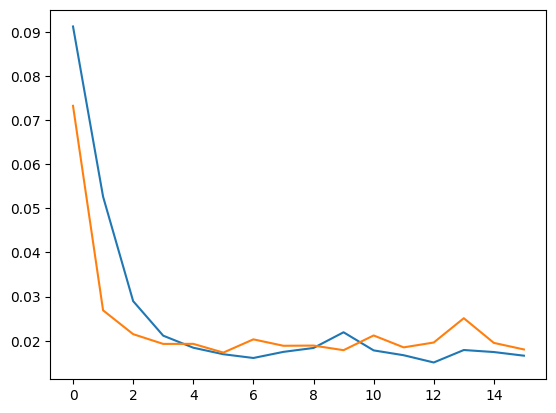

In [64]:
test_nn_model(model_1, X_train, X_test, y_train, y_test,
                  scaler_X, scaler_y,
                  optimizer=keras.optimizers.Adam,
                  metrics = None,
                  loss='mae', lr=0.001, batch_size=512, epochs=50,
                  early_stop=True, lr_schedule=True)

The scaling is more operable, but mathematically it shouldn't make a difference - apart from the fact that the scaling was done separately on training factor and target. Still, the results are very close to what we were able to achieve with "classical" ML methods (MAE of around 60k), even a little better, when looking at just the MAE score.

### Crossvalidating

However, we absolutely cannot just accept the results from a randomly chosen validation set - theoretically, especially the more data we have it should provide better results, but we cannot be sure, especially as this dataset is not that large.  
**Note**: As neural nets are usually used for large datasets, or datasets of complex datatypes, with usually the limitation being the inability to store the data in memory - KFold / CV methods are not usually used - here, we can, but it will require a bit more work from us

#### Crossvalidating function and data split

In [62]:
X = df_eng_proper.drop(['weekly_sales'], axis=1)
y = df_eng_proper['weekly_sales']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

k_fold = KFold(n_splits=5, shuffle=True)
# train_idx, test_idx = k_fold.split(X)

train_X_sets = []
train_y_sets = []
test_X_sets = []
test_y_sets = []
X_scalers = []
y_scalers = []

for train_idx, test_idx in k_fold.split(X):
    X_train = X.loc[train_idx, :]
    y_train = y.loc[train_idx]
    scaler_X.fit(X_train[X_cols])
    scaler_y.fit(pd.DataFrame(y_train))

    X_test = X.loc[test_idx, :]
    y_test = y.loc[test_idx]

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    
    X_train[X_cols] = scaler_X.transform(X_train[X_cols])
    X_test[X_cols] = scaler_X.transform(X_test[X_cols])
    y_train[y_col] = scaler_y.transform(y_train[y_col])
    y_test = scaler_y.transform(y_test[y_col])

    train_X_sets.append(X_train)
    train_y_sets.append(y_train)

    test_X_sets.append(X_test)
    test_y_sets.append(y_test)
    X_scalers.append(scaler_X)
    y_scalers.append(scaler_y)

#### Retraining the model in splits

In [65]:
maes = []
maes_inv = []

Redefining the model for initial reset

In [66]:
model_1 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

41/41 [==============================] - 0s 975us/step
mae:  0.015986771813823745
mae on inv scaled: 56521.540229519705
41/41 [==============================] - 0s 1ms/step
mae:  0.017308894097725416
mae on inv scaled: 61195.93262432848
41/41 [==============================] - 0s 950us/step
mae:  0.015998799281047187
mae on inv scaled: 56564.064659114345
41/41 [==============================] - 0s 999us/step
mae:  0.01536028672835885
mae on inv scaled: 54306.59401715765
41/41 [==============================] - 0s 1ms/step
mae:  0.017945282094817848
mae on inv scaled: 63445.89366113055


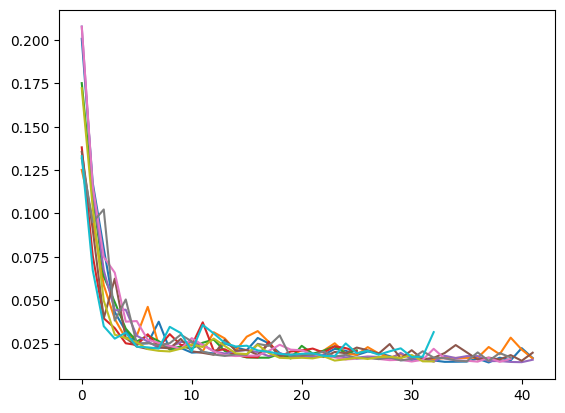

In [68]:
for i, (train_X, test_X, train_y, test_y, X_scaler, y_scaler) in enumerate(
    zip(train_X_sets, test_X_sets, train_y_sets, test_y_sets, X_scalers, y_scalers)):
    # create a clone of the model with untrained/initial weights
    model_clone = tf.keras.models.clone_model(model_1)
    # the new model still needs to be compiled - and it will be in the training function
    mae, mae_inv = test_nn_model(model_clone, train_X, test_X, train_y, test_y,
                  X_scaler, y_scaler,
                  optimizer=keras.optimizers.Adam,
                  metrics = None,
                  loss='mae', lr=0.001, batch_size=512, epochs=50,
                  early_stop=True, lr_schedule=True)
    maes.append(mae)
    maes_inv.append(mae_inv)

Clearly, there were some differences in training, some experiments stopped earlier than others and so on, otherwise, the MAE results range from 54 to 63 thousand dollars, which is indeed very close to the results from Project 1 and confirmed the lack of bias/chance factor from the singular experiment.

#### Explore the predictions further

In [90]:
# predictions, unscaling etc
y_pred = model_1.predict(X_test)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred))
print('mae on inv scaled:', mae)

51/51 [==============================] - 0s 2ms/step
mae on inv scaled: 48389.936182023004


In [95]:
X_test['y'] = y_test
X_test['y_pred'] = y_pred
X_test['error'] = abs(X_test['y'] - X_test['y_pred'])

In [96]:
X_test

,store,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,week_of_month,prev_weekly_sales,...,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff,y,y_pred,error
839,0.113636,0.0,0.799789,0.437876,0.962811,0.199827,0.470588,0.454545,0.75,0.402694,...,0.455052,0.648528,0.454545,0.450980,0.50,0.0,0.5,0.390247,0.386412,0.003836
928,0.136364,0.0,0.504863,0.632766,0.660529,0.451984,0.431373,0.454545,0.25,0.093432,...,0.397127,0.648528,0.454545,0.411765,0.00,0.0,0.5,0.113923,0.096112,0.017811
850,0.113636,1.0,0.854017,0.630261,0.969207,0.171459,0.686275,0.727273,0.25,0.384472,...,0.605608,0.648528,0.636364,0.666667,1.00,0.0,1.0,0.387422,0.365094,0.022328
3768,0.590909,0.0,0.259937,0.460421,0.107047,0.378378,0.039216,0.000000,0.75,0.371783,...,0.523007,0.648528,0.000000,0.019608,0.50,0.0,0.5,0.362192,0.349023,0.013170
3007,0.477273,0.0,0.330655,0.147295,0.094053,0.422082,0.156863,0.181818,0.00,0.193937,...,0.475047,0.648528,0.090909,0.137255,0.75,0.0,0.5,0.221469,0.226086,0.004617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,0.454545,0.0,0.606977,0.658818,0.938234,0.304581,0.215686,0.181818,0.75,0.156705,...,0.508627,0.648528,0.181818,0.196078,0.50,0.0,0.5,0.144033,0.152463,0.008430
1024,0.159091,0.0,0.760571,0.075651,0.874336,0.233468,0.529412,0.545455,0.50,0.178622,...,0.374337,0.648528,0.545455,0.509804,0.25,0.0,0.5,0.176974,0.175439,0.001535
1378,0.204545,0.0,0.666279,0.679359,0.037003,0.382883,0.843137,0.909091,0.00,0.439117,...,0.407199,0.648528,0.818182,0.823529,1.00,0.0,0.5,0.469546,0.445542,0.024004
2701,0.409091,0.0,0.714905,0.609719,0.120656,0.413456,0.529412,0.545455,0.50,0.378759,...,0.442309,0.648528,0.545455,0.509804,0.25,0.0,0.5,0.308076,0.359678,0.051602


In [110]:
X_test_rescaled = X_test.copy()

In [111]:
X_test_rescaled[X_cols] = scaler_X.inverse_transform(X_test[X_cols])
X_test_rescaled['y'] = scaler_y.inverse_transform(pd.DataFrame(X_test['y']))[:,0]
X_test_rescaled['y_pred'] = scaler_y.inverse_transform(pd.DataFrame(X_test['y_pred']))[:,0]
X_test_rescaled['error'] = abs(X_test_rescaled['y'] - X_test_rescaled['y_pred'])

In [114]:
X_test_rescaled.sort_values(['error'], ascending=False).head(5)

,store,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,week_of_month,prev_weekly_sales,...,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff,y,y_pred,error
1941,14.0,0.0,70.63,3.703,186.618927,8.625,35.0,9.0,1.0,2273470.62,...,0.054810,0.0,8.0,34.0,4.0,0.0,0.0,1750891.47,2360970.000,610078.530
4956,35.0,1.0,47.88,3.492,140.421786,8.745,47.0,11.0,4.0,820964.10,...,0.009000,0.0,11.0,46.0,3.0,0.0,1.0,1733822.40,1182067.000,551755.400
1381,10.0,1.0,60.68,3.760,129.836400,7.874,47.0,11.0,4.0,1869087.85,...,0.009567,0.0,11.0,46.0,3.0,0.0,1.0,2950198.64,2497375.500,452823.140
4905,35.0,0.0,41.81,3.046,136.607571,8.763,48.0,12.0,1.0,1781866.98,...,-0.082000,0.0,11.0,47.0,4.0,1.0,-1.0,982598.88,1389635.125,407036.245
1973,14.0,0.0,51.83,4.044,190.759596,8.567,15.0,4.0,3.0,2376022.26,...,0.074425,0.0,4.0,14.0,2.0,0.0,0.0,1912909.69,2248092.000,335182.310


In [115]:
X_test_rescaled.sort_values(['error'], ascending=False).tail(5)

,store,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,week_of_month,prev_weekly_sales,...,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff,y,y_pred,error
4139,29.0,1.0,73.30,3.921,138.472936,9.419,36.0,9.0,2.0,545844.91,...,0.095742,0.0,8.0,35.0,5.0,0.0,1.0,540811.85,5.406347e+05,177.1625
1839,13.0,0.0,65.97,3.756,130.829533,5.965,24.0,6.0,3.0,2182437.90,...,-0.060144,0.0,6.0,23.0,2.0,0.0,0.0,2152229.11,2.152056e+06,173.3600
1122,8.0,0.0,78.31,3.501,225.300865,5.679,22.0,6.0,1.0,895157.44,...,0.000287,0.0,5.0,21.0,4.0,0.0,0.0,921161.20,9.213024e+05,141.1750
327,3.0,0.0,57.72,2.771,215.207452,7.564,46.0,11.0,3.0,386635.03,...,-0.118174,0.0,11.0,45.0,2.0,0.0,0.0,372545.32,3.726641e+05,118.7425
2924,21.0,0.0,70.19,3.810,215.277268,7.931,17.0,4.0,5.0,801302.01,...,0.167603,0.0,4.0,16.0,4.0,0.0,0.0,783250.75,7.833262e+05,75.5000


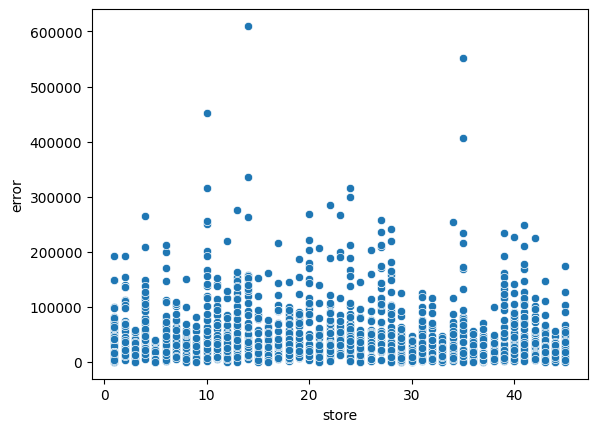

In [116]:
fig = sns.scatterplot(data=X_test_rescaled, x='store', y='error')

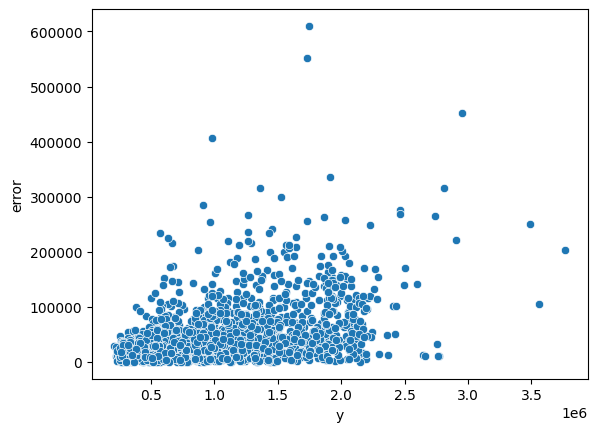

In [117]:
fig = sns.scatterplot(data=X_test_rescaled, x='y', y='error')

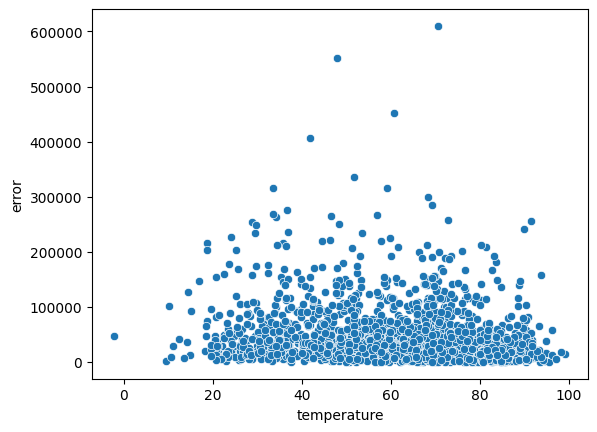

In [118]:
fig = sns.scatterplot(data=X_test_rescaled, x='temperature', y='error')

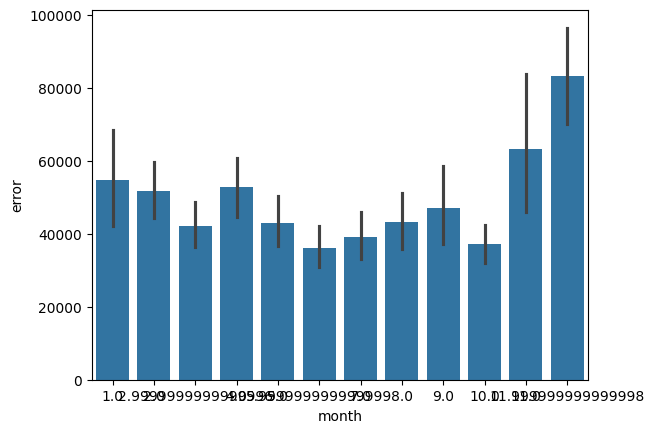

In [119]:
fig = sns.barplot(data=X_test_rescaled, x='month', y='error')

## TODO: GridSearch etc:
* https://www.tensorflow.org/tutorials/keras/keras_tuner
* https://docs.ray.io/en/latest/tune/index.html
* https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
* https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

## KerasTuner

In [69]:
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

#### How to use
In order to use KerasTuner, you neeed to define a callback function creating your desired model architecture, with some of the parameters replaced with hp (hyperparameter grid) values / placeholders for values from the grid.  
**Note:** the model also needs to be compiled, but fitting is left to KerasTuner

then, pass that callback to the tuner object, along with the objective, where to save the tested combinations etc

some parameters:
* max_trail: -This number is the number of combinations of hyperparameters to be tried/executed to find the best among them.
* execution_per_trail - It tells the tuner the number of times a single combination has to be executed in order to measure the combinations performance on the objective. Many times Neural Network models does not given exact same results but closer, when rerun, due to approximations and many other reasons. In order to avoid those pitfalls this parameter is useful.

then call tuner.search with supplied training and validating datasets, the numbers of epochs etc

#### Note:
Below function needs the shape of training input for the learning rate_scheduler, currently defined as X_train.shape[0] - not flexible

In [90]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(
        hp.Choice('units', [32, 64, 128, 512]), #neurons
        activation='relu', # could also be parametrized
        input_shape=[n_features]))
    model.add(layers.Dense(
        hp.Choice('units', [32, 64, 128, 512]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units', [32, 64, 128, 512]),
        activation='relu'))
    model.add(layers.Dense(1))

    lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    epochs = 50
    batch_size = 256
    loss = 'mae'
    # metrics = [tf.keras.metrics.MeanAbsoluteError,]
    metrics = ['mae']
    optimizer = tf.keras.optimizers.Adam
              
    # prepare the learning rate decay
    # https://stackoverflow.com/questions/61552475/
    # properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
    train_size = X_train.shape[0]
    initial_lr = lr
    final_lr = initial_lr / 100
    lr_decay_factor  = (final_lr / initial_lr) ** (1/epochs)
    steps_per_epoch = int(train_size/batch_size)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr,
                decay_steps=steps_per_epoch,
                decay_rate=lr_decay_factor,
                staircase=True)

    optim = optimizer(
        learning_rate = lr_schedule
    )

    # model compilation   
    model.compile(
        optimizer = optim,
        loss = loss,
        metrics = metrics
    )

    return model
    

In [86]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials = 20
)

Reloading Tuner from .\untitled_project\tuner0.json


#### Note: you can use the tuner function with the same parameters as fitting the model, maning, you CAN use callbacks like earlystopping
Example: tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [91]:
# prepare early stopping                    
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [93]:
tuner.search(X_train, y_train,
             epochs=50,
             batch_size = 256,
             callbacks = [early_stopping],
             verbose = False,
             validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

In [94]:
best_model

In [95]:
# predictions, unscaling etc
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae_inv = mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred))
print('mae: ', mae)
print('mae on inv scaled:', mae_inv)

41/41 [==============================] - 0s 1000us/step
mae:  0.01539118609693407
mae on inv scaled: 54415.83563811189


#### Exploring the hypertuned model further
1. Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
2. Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [97]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.001.



In [98]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_model_2 = tuner.hypermodel.build(best_hps)
history = best_model_2.fit(X_train, y_train,
             epochs=50,
             batch_size = 256,
             verbose = False,
             validation_data=(X_test, y_test))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


<Axes: >

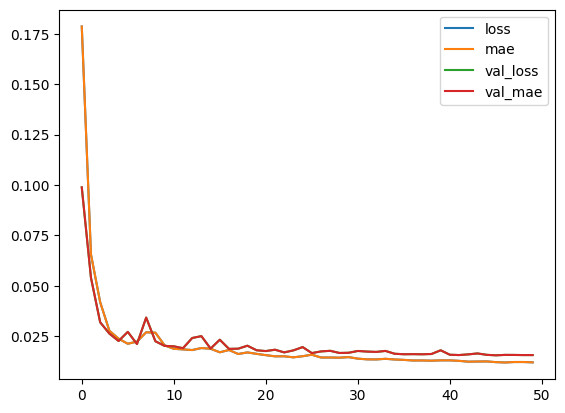

In [99]:
pd.DataFrame(history.history).plot()

### Conclusion: Pretty much the same model, therefore, the same results